<a href="https://colab.research.google.com/github/danadria/Skills-Lab-Introduction-to-Transformers-BERT-and-Explainable-NLP/blob/main/skills_lab_sentiment_analysis_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Transformers for Text Analysis

<img src="img/uu_logo.png" alt="logo" align="right" title="UU" width="50" height="20" />

#### Transformers workshop

In this practical, we are going to work with transformers! Similar to the first practical, we will be going to use the **Drug Review Dataset** from drugs.com which is publicly availabe at the UCI Machine Learning repository.

More specifically, we are going to perform sentiment classification of drug reviews using a transformer model, have a look under its hood, try to explain the model predictions using [Shapley Additive Explanations \(SHAP\)](https://arxiv.org/abs/1705.07874), a method of explainable AI, and fine-tune the model.

Our BERT-variant of choice of transformers is [DistilBERT](https://arxiv.org/abs/1910.01108), a light-weight transformer whose performance is comparable to Google's [BERT base model](https://arxiv.org/abs/1810.04805).

In [1]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import transformers
import pandas as pd
import numpy as np
import random

C:\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set the seeds so we might be able to get the same results!
seed = 137
random.seed(seed)
np.random.seed(seed)
transformers.set_seed(seed)

## Overview
1. We will use an off-the-shelf sentiment analysis pipeline from the Hugging Face [`transformers`](https://huggingface.co/docs/transformers/index) module to classify two reviews.
2. We will dissasemble the sentiment analysis pipeline by performing the same analysis as in Part 1 step-by-step.
3. We will open the black box and explore which tokens were most important for DistilBERT's sentiment classification. We do this using [Shapley Additive Explanations \(SHAP\)](https://arxiv.org/abs/1705.07874).
4. We will fine-tune DistilBERT on a sample of the Drug Review Dataset.

## Load Data

Let's first load the data and run the preprocessing code from the first lab. Below more information on the dataset:

- The Drug Review Dataset provides patient reviews on specific drugs along with related conditions and a 10-star patient rating reflecting the overall patient satisfaction.
- The data was obtained by crawling online pharmaceutical review sites.
- The dataset is of shape (161297, 7) i.e. It has 7 features including the review and 161297 Data Points or entries.

The features are 'drugName' which is the name of the drug, 'condition' which is the condition the patient is suffering from, 'review' is the patients review, 'rating' is the 10-star patient rating for the drug, 'date' is the date of the entry and the 'usefulcount' is the number of users who found the review usefule.

In [3]:
# load the data
df_train = pd.read_csv("data/drugsComTrain_raw.tsv",sep='\t')
df_test = pd.read_csv("data/drugsComTest_raw.tsv",sep='\t')

# Prepare the label for training
df_train['label'] = 'neutral'
df_train.loc[df_train['rating'] >= 6, 'label'] = 'positive'
df_train.loc[df_train['rating'] < 6, 'label'] = 'negative'

# Prepare the label for test
df_test['label'] = 'neutral'
df_test.loc[df_test['rating'] >= 6, 'label'] = 'positive'
df_test.loc[df_test['rating'] < 6, 'label'] = 'negative'

## Off-the-shelf Sentiment Analysis Pipeline

Since sentiment analysis is a popular application, there are off-the-shelf pipelines which we can use to quickly classify documents by sentiment. One such pipeline is part of the Hugging Face `transformers` module.

In this module, there are various pre-trained BERT models available for many different NLP tasks based on the General Language Understanding Evaluation (GLUE) [benchmark resources](https://huggingface.co/datasets/glue).

To showcase how to use the sentiment analysis pipeline, we will compare two random drug reviews from our dataset:

In [4]:
review1 = df_train.loc[1, 'review']
review2 = df_train.loc[7456, 'review']

You can skim the reviews.

In [5]:
print(review1)

"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the most effective."


In [6]:
print(review2)

"I received the Implanon after giving birth to my first son. I thought this would be great because I forget to take the pill. Well it is great. I am not pregnant. However, I am having the WORST side effect of them all. I AM LOOSING MY HAIR. I have got to get it out. I walked in thinking that this would not happen to me, side effects never effect me. Good luck to the rest of you."


 What is your guess of the sentiment of these reviews? On the scale 1-10, what rating do you think the respective authors gave the drug?

In [7]:
print("The rating for review1 is", df_train.loc[1, 'rating'])
print("The label for review1 is", df_train.loc[1, 'label'])
print("The rating for review2 is", df_train.loc[7456, 'rating'])
print("The label for review2 is", df_train.loc[7456, 'label'])

The rating for review1 is 8.0
The label for review1 is positive
The rating for review2 is 3.0
The label for review2 is negative


**1. Set up and fit a sentiment analysis pipeline to predict the sentiment of the two reviews. Define the model as `'distilbert-base-uncased-finetuned-sst-2-english'`**

Our BERT model will be Distilbert base uncased. Uncased means that the model disregards casing (upper or lower case). In particular, we use a distilbert version which has been fine-tuned for binary sentiment classification using the [Stanford Sentiment Treebank](https://arxiv.org/abs/cs/0506075) (SST-2; Pang and Lee, 2005) corpus.

In [8]:
sentiment_pipeline = transformers.pipeline("sentiment-analysis", model = 'distilbert-base-uncased-finetuned-sst-2-english')

In [9]:
sentiment_pipeline(review1) # predict sentiment

[{'label': 'POSITIVE', 'score': 0.9062138795852661}]

In [10]:
sentiment_pipeline(review2) # predict sentiment

[{'label': 'NEGATIVE', 'score': 0.9842180013656616}]

For each review, we see the output label and the associated probability.

Do you agree with model predictions?

Here is the ground truth:

Review 1 is a positive review with a rating of 8/10.

Review 2 is a negative review with a rating of 3/10.

Does this match your human prediction?

Now we are going to show you how to build your own sentiment analysis pipeline from scratch. In practice, you can use the already existing one as we just have above, but it might be helpful to understand the steps associated with setting up a transformer-based pipeline for other applications you might work on.

## Sentiment Analysis Pipeline - Deconstructed

We perform the same sentiment analysis on the same two reviews - this time step-by-step.

**2. Define the tokenizer and the model. For the tokenizer, use the pretrained DistilBERT tokenizer and for the model use `distilbert-base-uncased-finetuned-sst-2-english`.**

In [11]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = transformers.DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

**3. Tokenize the `review1` and `review2` objects. Pad and truncate the sequences, and return PyTorch (`pt`) tensors. Save the output object as `encoding`.**


In [12]:
encoding = tokenizer([review1, review2], padding = True, truncation = True, return_tensors = 'pt') # tokenize the reviews

BERT and several other transformer models use tokenizers based on [WordPiece](https://huggingface.co/learn/nlp-course/chapter6/6?fw=pt), a subword tokenization algorithm. The main advantage of a subword tokenizer is that it interpolates between word-based and character-based tokenization. Common words get a slot in the vocabulary, but the tokenizer can fall back to word pieces and individual characters for unknown words.

Since batched inputs (our reviews) are of different lengths, they cannot be converted to fixed-size tensors to befed to the model.

There are two main strategies for solving this problem -- *padding* and *truncation*.

In order to create rectangular tensors from batches of varying lengths, padding adds a special padding token to ensure shorter sequences will have the same length as either the longest sequence in a batch or the maximum length accepted by the model. Truncation works in the other direction by truncating long sequences.

<blockquote>

`padding = True`: pad to the longest sequence in the batch (no padding is applied if you only provide a single sequence).

`truncation = True`: truncate to a maximum length specified by the max_length argument or the maximum length accepted by the model if no max_length is provided (max_length=None).

</blockquote>


**4. Inspect the `encoding` object by prining the first reveiw's input ids.**

In [13]:
print(encoding['input_ids'][0]) # first review's input_ids

tensor([  101,  1000,  2026,  2365,  2003,  8576,  2083,  2010,  2959,  2733,
         1997, 20014, 19496,  2615,  1012,  2057,  2150,  4986,  2043,  2002,
         2211,  2023,  2197,  2733,  1010,  2043,  2002,  2318,  2635,  1996,
         3284, 13004,  2002,  2097,  2022,  2006,  1012,  2005,  2048,  2420,
         1010,  2002,  2071,  6684,  2131,  2041,  1997,  2793,  1010,  2001,
         2200, 27987,  2100,  1010,  1998,  7771,  2005,  3053,  1022,  2847,
         2006,  1037,  3298,  2188,  2013,  2082, 10885,  1006,  2200,  5866,
         2005,  2032,  1012,  1007,  1045,  2170,  2010,  3460,  2006,  6928,
         2851,  1998,  2016,  2056,  2000,  6293,  2009,  2041,  1037,  2261,
         2420,  1012,  2156,  2129,  2002,  2106,  2012,  2082,  1010,  1998,
         2007,  2893,  2039,  1999,  1996,  2851,  1012,  1996,  2197,  2048,
         2420,  2031,  2042,  3291,  2489,  1012,  2002,  2003,  2172,  2062,
         5993,  3085,  2084,  2412,  1012,  2002,  2003,  2625, 

We see that BERT assigns a unique id to each token (`input_ids`).

**5. Convert first review's input ids to tokens using `convert_ids_to_tokens` to see how the text got tokenized.**

In [14]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])) # first review's tokens

['[CLS]', '"', 'my', 'son', 'is', 'halfway', 'through', 'his', 'fourth', 'week', 'of', 'int', '##uni', '##v', '.', 'we', 'became', 'concerned', 'when', 'he', 'began', 'this', 'last', 'week', ',', 'when', 'he', 'started', 'taking', 'the', 'highest', 'dose', 'he', 'will', 'be', 'on', '.', 'for', 'two', 'days', ',', 'he', 'could', 'hardly', 'get', 'out', 'of', 'bed', ',', 'was', 'very', 'crank', '##y', ',', 'and', 'slept', 'for', 'nearly', '8', 'hours', 'on', 'a', 'drive', 'home', 'from', 'school', 'vacation', '(', 'very', 'unusual', 'for', 'him', '.', ')', 'i', 'called', 'his', 'doctor', 'on', 'monday', 'morning', 'and', 'she', 'said', 'to', 'stick', 'it', 'out', 'a', 'few', 'days', '.', 'see', 'how', 'he', 'did', 'at', 'school', ',', 'and', 'with', 'getting', 'up', 'in', 'the', 'morning', '.', 'the', 'last', 'two', 'days', 'have', 'been', 'problem', 'free', '.', 'he', 'is', 'much', 'more', 'agree', '##able', 'than', 'ever', '.', 'he', 'is', 'less', 'emotional', '(', 'a', 'good', 'thing'

Note that BERT-based models also operate with special tokens:

<br>

| Token      | Token ID | Meaning                                 |
|:----------:|:--------:|:---------------------------------------:|
| `[CLS]`    | `101`    | Beginning of input                     |
| `[SEP]`    | `102`    | End of input or sentence               |
| `[MASK]`   | `103`    | Masked tokens the model should predict |
| `[PAD]`    | `0`      | Padding                                 |
| `[UNK]`    | `100`    | Unknown token not in training data     |

</blockquote>


**6. Predict the sentiment of the two reviews. In order to do this, import `torch`, and define the `output` object using the model, input ids and attention mask.**

Now we are ready to do some sentiment prediction. We import `torch`, define our model by feeding it `input_ids` and `attention_mask`. The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.

In [15]:
# prediction of sentiment
import torch
output = model(input_ids = encoding['input_ids'], attention_mask = encoding['attention_mask'])

In [16]:
print("Predicted logits:\n\n", output['logits']) # logits

Predicted logits:

 tensor([[-1.0547,  1.2136],
        [ 2.2059, -1.9270]], grad_fn=<AddmmBackward0>)


In [17]:
print("Predicted probabilities:\n\n", torch.nn.functional.softmax(output['logits'], dim=-1)) # from logits to probabilities

Predicted probabilities:

 tensor([[0.0938, 0.9062],
        [0.9842, 0.0158]], grad_fn=<SoftmaxBackward0>)


In [18]:
prediction = torch.argmax(output['logits'], 1) # from logits to a binary class
print("Predicted classes:\n", prediction)

Predicted classes:
 tensor([1, 0])


How do the output sentiments and probabilities compare to the off-the-shelf sentiment classification pipeline we used in the previous section?

## Feature Importance with SHAP

Now that we have classified our two reviews, we might want to explain DistilBERT's predictions using [Shapley Additive Values (SHAP)](https://shap.readthedocs.io/en/latest/).


**7. Install the `shap` module, import `shap.Explainer` and feed it the `sentiment_pipeline` model. Pass the two drug reviews as input for the explainer.**

*Note. The computation of Shapley values for DistilBERT explaining our two reviews should take couple of minutes, but can be very computationally intensive in most real life applications.*

In [19]:
# !pip install -q shap
import shap
explainer = shap.Explainer(sentiment_pipeline)
shap_values = explainer([review1, review2])

 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:26<00:00, 16.86it/s]
500it [00:27, 16.89it/s]                                                                                               
504it [00:27, 16.53it/s]
PartitionExplainer explainer: 3it [01:39, 49.82s/it]                                                                   


**8. A nice thing about the `shap` module is that it comes with a built-in visualizer. Use `shap.plots.text` to visualize the shap values for the first and the second drug review.**

In [20]:
shap.plots.text(shap_values[0]) # first review

In [21]:
shap.plots.text(shap_values[1]) # second review

Features highlighted in red are increasing the predicted probability, while features highlighted in blue are lowering the predicted probability.

## Fine-tuning BERT using the Drug Review Dataset

Now let's fine-tune a sentiment analysis of the Drug Review dataset using the off-the-shelf sentiment analysis pipeline.

Since the DistilBERT we are using was trained on the Stanford Sentiment Treebank dataset, we also fine-tune our model for the Drug Review dataset. In practice, this might not be neccesary for this particular application, but might be good to see how it can be done.

In [22]:
from datasets import load_dataset

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import evaluate
import numpy as np

**9. Using the codes below, inspect the dataset and sample 5 to 10% of the `train` and `test`, because fine-tuning the entire dataset would be too resource-intensive to run in this practical.**

In [23]:
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,negative
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,positive


<Axes: >

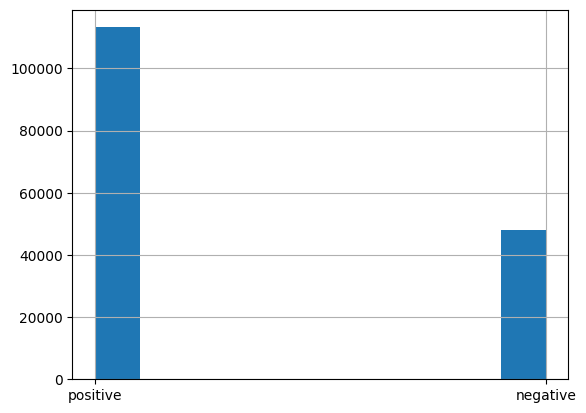

In [24]:
df_train['label'].hist()

In [25]:
df_train = df_train[['label','review']]
df_test = df_test[['label','review']]

In [26]:
# target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
target_map = { 'positive': 1, 'negative': 0}
df_train['target'] = df_train['label'].map(target_map)
df_test['target'] = df_test['label'].map(target_map)

In [27]:
# Save data to new csv file. Because transformers required special format of dataset to perform operations on it, 
# which we will give using load_dataset class. 
df1 = df_train[['review','target']]
df1.columns = ['sentence','label']
df1.to_csv('train.csv', index = False)

In [28]:
df1 = df_test[['review','target']]
df1.columns = ['sentence','label']
df1.to_csv('test.csv', index = False)

In [29]:
raw_dataset = load_dataset('csv', 
              data_files = { 'train': 'train.csv',
                             'test': 'test.csv'})

Extracting data files: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 663.08it/s]
Generating train split: 161297 examples [00:00, 174555.16 examples/s]
Generating test split: 53766 examples [00:00, 192227.85 examples/s]


In [30]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 53766
    })
})

In [32]:
# Because fine-tuning on the dataset would be too resource-intensive to run in this practical, 
# we will work with a randomly sampled 5% of the original train and test dataset size.
drug_data = raw_dataset
drug_data['train'] = drug_data['train'].shuffle(seed=42).select(range(int(0.05*len(raw_dataset['train']))))
drug_data['test'] = drug_data['test'].shuffle(seed=42).select(range(int(0.05*len(raw_dataset['test']))))
drug_data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 403
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 134
    })
})

**10. Create a preprocessing function to tokenize `text` and truncate sequences to be no longer than DistilBERT’s maximum input length. To apply the preprocessing function over the entire dataset, use Datasets `map` function. You can speed up map by setting `batched=True` to process multiple elements of the dataset at once.**

In [33]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
#checkpoint = 'bert-base-cased'
checkpoint = 'distilbert-base-uncased-finetuned-sst-2-english'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

In [34]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [35]:
tokenized_data = drug_data.map(tokenize_fn, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 1651.45 examples/s]


**12. Load the DistilBERT model we had used earlier using `AutoModelForSequenceClassification` and look at the summary of the model.**

In [36]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

Let's install torchinfo which is a Python library for getting information about PyTorch models and tensors. It provides a convenient way to inspect the architecture of a PyTorch model, including the shape and size of the tensors that are passed between the layers, as well as the number of parameters and memory usage of each layer.


In [37]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0

**13. Use the code below ot setup the training arguments and define the metrics.**

In [38]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=2,
                                  per_device_train_batch_size=10,
                                  per_device_eval_batch_size=10)

In [39]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

**14. Fine-tune model using the `Trainer` function. You can use the following training arguments.**

In [40]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_data["train"],
                  eval_dataset = tokenized_data["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

In [41]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.469020,0.820896,0.820896
2,No log,0.532600,0.828358,0.828358


TrainOutput(global_step=82, training_loss=0.3808192741580126, metrics={'train_runtime': 233.0466, 'train_samples_per_second': 3.459, 'train_steps_per_second': 0.352, 'total_flos': 40715614309560.0, 'train_loss': 0.3808192741580126, 'epoch': 2.0})

In [229]:
# the code here can be uncommented to clear the memory if you are using your machine for the practical
# import torch
# torch.cuda.empty_cache()

# import gc
# del df1, df_train, df_test
# gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)


**15. Load the model you just fine-tuned into a pipeline and classify a sentence of choice.**

In [42]:
from transformers import pipeline
fine_tuned_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-82')


In [43]:
fine_tuned_model(review1)

[{'label': 'POSITIVE', 'score': 0.9956554174423218}]

In [44]:
fine_tuned_model(review2)

[{'label': 'POSITIVE', 'score': 0.9846466183662415}]

In [45]:
fine_tuned_model("It was awful.")

[{'label': 'NEGATIVE', 'score': 0.9894874095916748}]

In [46]:
fine_tuned_model("The drug has many painful side effects.")

[{'label': 'NEGATIVE', 'score': 0.9243993759155273}]

In [47]:
predictions = fine_tuned_model(raw_dataset['test']['sentence'])

In [48]:
predictions

[{'label': 'POSITIVE', 'score': 0.9302699565887451},
 {'label': 'NEGATIVE', 'score': 0.7233402132987976},
 {'label': 'POSITIVE', 'score': 0.9857465028762817},
 {'label': 'POSITIVE', 'score': 0.9613932371139526},
 {'label': 'POSITIVE', 'score': 0.9978813529014587},
 {'label': 'POSITIVE', 'score': 0.9953676462173462},
 {'label': 'NEGATIVE', 'score': 0.8895398378372192},
 {'label': 'POSITIVE', 'score': 0.9331142902374268},
 {'label': 'POSITIVE', 'score': 0.9989683628082275},
 {'label': 'NEGATIVE', 'score': 0.8191303014755249},
 {'label': 'POSITIVE', 'score': 0.9034171104431152},
 {'label': 'POSITIVE', 'score': 0.9983579516410828},
 {'label': 'POSITIVE', 'score': 0.9903417825698853},
 {'label': 'POSITIVE', 'score': 0.997307300567627},
 {'label': 'POSITIVE', 'score': 0.9858860969543457},
 {'label': 'NEGATIVE', 'score': 0.5800550580024719},
 {'label': 'POSITIVE', 'score': 0.99184250831604},
 {'label': 'POSITIVE', 'score': 0.878173828125},
 {'label': 'POSITIVE', 'score': 0.9989493489265442},


### Further reading
*   How to fine-tune a model: https://huggingface.co/docs/transformers/training
*   Fine-Tuning Transformers with custom dataset: https://medium.com/@lokaregns/fine-tuning-transformers-with-custom-dataset-classification-task-f261579ae068